In [1]:
import tensorflow.compat.v1 as tf
tf.enable_eager_execution()
tf.disable_v2_behavior()
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Reshape, Flatten, Lambda, Conv1DTranspose
from tensorflow.compat.v1.keras import backend as K
from tensorflow.compat.v1.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import numpy as np
np.random.seed(5)
import matplotlib.pyplot as plt

class Gaussian:
    def __init__(self, mu=None, sigma=None) -> None:
        '2D Gaussian pdf'
        D = 2
        self.mu = mu if mu is not None else  10 * (np.random.random(D) - 0.5)
        self.sigma = sigma if sigma is not None else 0.05*(np.eye(2) + 0.1*np.random.random((2,2)))
        self.sigma = (self.sigma + self.sigma.T)/2   # to make it symmetric
        self.sigmainv = np.linalg.inv(self.sigma)
        self.Z = 2*np.pi*np.sqrt(np.linalg.det(self.sigma))
    def sample(self, S=1):
        'return SxD np array'
        return np.random.multivariate_normal(self.mu, self.sigma, size=S)
    def prob(self, x_s):
        'x_s is SxD; returns an np array of len S'
        retval = []
        for x_mu in (x_s-self.mu):
             retval.append(np.exp(-0.5*(x_mu).T.dot(self.sigmainv).dot(x_mu))/self.Z)
        return np.array(retval)
        
class GMM:
    def __init__(self, N=5) -> None:
        'GMM with N Gaussian components'
        self.components = [Gaussian() for _ in range(N)] 
        self.weights = np.random.random(N)
        self.weights /= np.sum(self.weights)
    def sample(self, S=1):
        print(self.weights)
        retval = []
        count_z = np.random.multinomial(S, self.weights)
        print(count_z)
        for z, count in enumerate(count_z):
            retval.append(self.components[z].sample(S=count))
        return np.vstack(retval)
    def prob(self, x_s):
        retval = []
        p = np.zeros(len(x_s))
        for z, w in enumerate(self.weights):
            p += w * self.components[z].prob(x_s)
        return p

def plot_samples_2d(data, filename=None):
    'data is SxD'
    plt.figure(figsize=(5,5))
    plt.scatter(data[:, 0], data[:, 1]) 
    if filename:
        plt.savefig('./%s'%(filename) + ".png", format="png")

In [3]:
# Create encoder network

latent_dim = 2 # dimension of latent variable

inputs = Input(shape = (2,1))
flat = Flatten()(inputs)
input=Dense(32, activation = 'relu')(flat)
input=Reshape((32,1))(input)

conv1 = Conv1D(16, 3, activation = 'relu', padding = "SAME")(input)
conv1_1 = Conv1D(16, 3, activation = 'relu', padding = "SAME")(conv1)
pool1 = MaxPooling1D(pool_size = 2, strides = 2)(conv1_1)
conv2 = Conv1D(32, 3, activation = 'relu', padding = "SAME")(pool1)

flat = Flatten()(conv2)
input_to_z = Dense(32, activation = 'relu')(flat)
mu = Dense(latent_dim, name='mu')(input_to_z)
sigma = Dense(latent_dim, name='log_var')(input_to_z)

encoder = Model(inputs, (mu, sigma))

In [4]:
# create latent distribution function and generate vectors

def sampling(args):
    mu, sigma = args
    epsilon = K.random_normal(shape=(K.shape(mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return mu + K.exp(sigma) * epsilon

z = Lambda(sampling)([mu, sigma])

In [5]:
#create decoder network which is reverse of encoder
decoder_inputs = Input(K.int_shape(z)[1:])
dense_layer_d = Dense(32, activation = 'relu')(decoder_inputs)
output_from_z_d = Reshape((32,1))(dense_layer_d)
trans1_d = Conv1DTranspose(32, 3, padding='same', activation='relu', strides=2)(output_from_z_d)
trans1_1_d = Conv1DTranspose(16, 3, padding='same', activation='relu', strides=2)(trans1_d)
trans2_d = Conv1DTranspose(1, 3, padding='same', activation='relu')(trans1_1_d)
flat = Flatten()(trans2_d)
trans2_d = Dense(2)(flat)

decoder = Model(decoder_inputs, trans2_d)
z_decoded = decoder(z)
print(inputs[0].shape, inputs[1].shape, z_decoded.shape)

(2, 1) (2, 1) (?, 2)


In [6]:
#calculate reconstruction loss and KL divergence

class calc_output_with_los(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        import tensorflow
        tensorflow.compat.v1.disable_v2_behavior()
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        xent_loss = tensorflow.compat.v1.keras.metrics.binary_crossentropy(x, z_decoded)

        kl_loss = -5e-4 * K.mean(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

print(inputs[0].shape, inputs[1].shape, z_decoded.shape)
outputs = calc_output_with_los()([inputs, z_decoded])
print(inputs[0].shape, inputs[1].shape, z_decoded.shape)

(2, 1) (2, 1) (?, 2)
(2, 1) (2, 1) (?, 2)


[0.08954024 0.30634303 0.34121746 0.01003852 0.25286076]
[105 393 454  16 312]
Train on 1280 samples, validate on 1280 samples
1280/1280 [==============================] - 1s 1ms/sample - loss: -15.3112 - val_loss: -15.4892
[0.08954024 0.30634303 0.34121746 0.01003852 0.25286076]
[128 383 448   8 313]
Train on 1280 samples, validate on 1280 samples
1280/1280 [==============================] - 0s 322us/sample - loss: -16.6228 - val_loss: -17.9434
[0.08954024 0.30634303 0.34121746 0.01003852 0.25286076]
[108 363 440   8 361]
Train on 1280 samples, validate on 1280 samples
1280/1280 [==============================] - 0s 312us/sample - loss: -21.5681 - val_loss: -24.3428
[0.08954024 0.30634303 0.34121746 0.01003852 0.25286076]
[119 404 436   7 314]
Train on 1280 samples, validate on 1280 samples
1280/1280 [==============================] - 0s 298us/sample - loss: -23.7331 - val_loss: -24.6083
[0.08954024 0.30634303 0.34121746 0.01003852 0.25286076]
[105 387 448   5 335]
Train on 1280 sampl

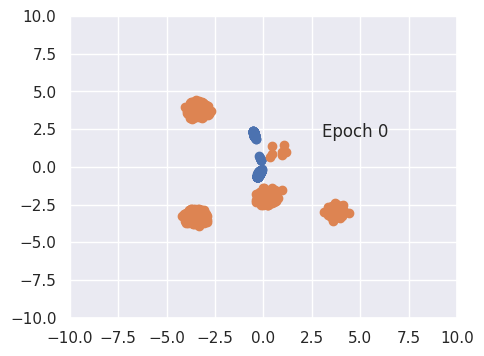

In [7]:
# define variational autoencoder model and train it
import seaborn as sns
from matplotlib import animation
import warnings
warnings.filterwarnings('ignore')
sns.set()
fig, ax = plt.subplots(dpi=100, figsize=(5, 4))
batch_size=64*20
G=GMM()
vae = Model(inputs, outputs)
m = 64
n_epoch = 50
vae.compile(optimizer='adam', loss=None)
#vae.compile(optimizer='adam', loss=None, metrics=['accuracy', 'mse', 'mae', 'mape', 'cosine'])
def animate(step):
  m=64
  X_train = np.reshape(G.sample(batch_size), (batch_size, 2, 1))
  X_test = X_train
  vae.fit(X_train, epochs=1, batch_size=m, shuffle=True, validation_data=(X_test, None))
  (m, s)=encoder.predict(X_train)
  z = Lambda(sampling)([m, s])
  z_decoded=decoder.predict(z, steps=1)
  fig.clf()
  plt.scatter(z_decoded[:,0], z_decoded[:,1])
  plt.scatter(X_train[:,0], X_train[:,1])
  plt.xlim([-10,10])
  plt.ylim([-10,10])
  plt.text(3, 2, "Epoch {}".format(step))

anim = animation.FuncAnimation(fig, animate, frames=n_epoch, interval = 10)
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()

[0.08954024 0.30634303 0.34121746 0.01003852 0.25286076]
[0 1 0 0 0]


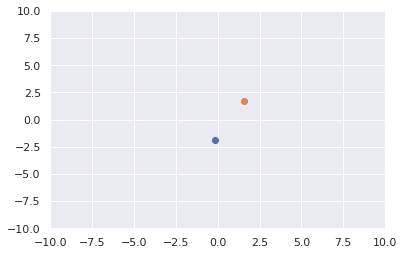

In [62]:
batch_size=1
X_train=np.reshape(G.sample(batch_size), (batch_size, 2, 1))
(x, y) = encoder.predict(X_train)
z = Lambda(sampling)([x, y])
sess = tf.Session() #create session 
sess.run(tf.global_variables_initializer()) #initialize variables
z = sess.run(z[:, :]) #evaluate image tensor inside sessio
plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

[0.08954024 0.30634303 0.34121746 0.01003852 0.25286076]
[ 51 158 163   7 121]


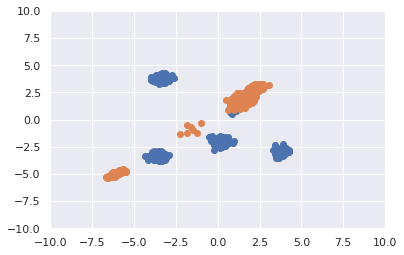

In [28]:
batch_size=500
X_train=np.reshape(G.sample(batch_size), (batch_size, 2, 1))
(x, y) = encoder.predict(X_train)
z = Lambda(sampling)([x, y])
sess = tf.Session() #create session 
sess.run(tf.global_variables_initializer()) #initialize variables
z = sess.run(z[:, :]) #evaluate image tensor inside sessio
plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()